In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv,SAGEConv,GCNConv, global_mean_pool, global_max_pool
from torch_geometric.data import DataLoader, Batch
from torch.nn import Linear, LogSoftmax

In [5]:
#préparation des données

In [6]:
from torch_geometric.datasets import UPFD
train_data1 = UPFD(root=".", name="gossipcop", feature="profile", split="train")
test_data1 = UPFD(root=".", name="gossipcop", feature="profile", split="test")
print("Train Samples: ", len(test_data1))
print("Test Samples: ", len(train_data1))
test_loader1 = DataLoader(train_data1, batch_size=128, shuffle=False)
train_loader1 = DataLoader(test_data1, batch_size=128, shuffle=False)

Extracting ./gossipcop/raw/data.zip
Processing...


Train Samples:  3826
Test Samples:  1092


Done!
/home/khed-sofiane/anaconda3/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
from torch_geometric.datasets import UPFD
train_data2= UPFD(root=".", name="gossipcop", feature="bert", split="train")
test_data2= UPFD(root=".", name="gossipcop", feature="bert", split="test")
print("Train Samples: ", len(test_data2))
print("Test Samples: ", len(train_data2))
test_loader2 = DataLoader(train_data2, batch_size=128, shuffle=False)
train_loader2= DataLoader(test_data2, batch_size=128, shuffle=False)

Processing...
Done!


Train Samples:  3826
Test Samples:  1092


In [8]:
class SAGELayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SAGELayer, self).__init__()
        self.attention = SAGEConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.attention(x, edge_index)

In [9]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,hidden_ch, out_channels):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        self.conv1 = SAGELayer(in_channels, hidden_ch)
        self.conv2 = SAGELayer(hidden_ch, hidden_ch)
        self.conv3 = SAGELayer(hidden_ch, hidden_channels)

    def forward(self, x, edge_index):
        #print(x.shape)
        h = F.elu(self.conv1(x, edge_index))
        #print(h.shape)
        h = F.elu(self.conv2(h, edge_index))
        h = F.elu(self.conv3(h, edge_index))
        return h

In [10]:
class MultiHeadCoAttentionLayer(nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2, num_heads,dropout_rate=0.01):
        super(MultiHeadCoAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.hidden_channels1 = hidden_channels1
        self.hidden_channels2 = hidden_channels2

        # Define separate attention weights for each head
        self.query1 = nn.Linear(hidden_channels1, hidden_channels1 * num_heads, bias=False)
        self.key1 = nn.Linear(hidden_channels1, hidden_channels1 * num_heads, bias=False)
        self.value1 = nn.Linear(hidden_channels1, hidden_channels1 * num_heads, bias=False)

        self.query2 = nn.Linear(hidden_channels2, hidden_channels2 * num_heads, bias=False)
        self.key2 = nn.Linear(hidden_channels2, hidden_channels2 * num_heads, bias=False)
        self.value2 = nn.Linear(hidden_channels2, hidden_channels2 * num_heads, bias=False)

        # Output linear layers
        self.out1 = nn.Linear(hidden_channels1 * num_heads, hidden_channels1)
        self.out2 = nn.Linear(hidden_channels2 * num_heads, hidden_channels2)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x1, x2):
        """
        x1: Tensor of shape [batch_size, hidden_channels1]
        x2: Tensor of shape [batch_size, hidden_channels2]
        """
        
        # Multi-head queries, keys, and values
        Q1 = self.query1(x1).view(-1, self.num_heads, self.hidden_channels1)
        K2 = self.key2(x2).view(-1, self.num_heads, self.hidden_channels2)
        V2 = self.value2(x2).view(-1, self.num_heads, self.hidden_channels2)

        Q2 = self.query2(x2).view(-1, self.num_heads, self.hidden_channels2)
        K1 = self.key1(x1).view(-1, self.num_heads, self.hidden_channels1)
        V1 = self.value1(x1).view(-1, self.num_heads, self.hidden_channels1)
       

        # Scaled dot-product attention
        attn_scores1 = torch.matmul(Q1, K2.transpose(-2, -1)) / (self.hidden_channels2 ** 0.5)
        attn_weights1 = F.softmax(attn_scores1, dim=-1)
        
        
        # Apply dropout to attention weights
        attn_weights11 = self.dropout(attn_weights1)
        attended_x1 = torch.matmul(attn_weights11, V2)
      

        attn_scores2 = torch.matmul(Q2, K1.transpose(-2, -1)) / (self.hidden_channels1 ** 0.5)
        attn_weights2 = F.softmax(attn_scores2, dim=-1)
       
        # Apply dropout to attention weights
        attn_weights22 = self.dropout(attn_weights2)
        attended_x2 = torch.matmul(attn_weights2, V1)
     

        # Concatenate heads and project back to the original dimension
        attended_x1 = attended_x1.view(-1, self.num_heads * self.hidden_channels1)
        attended_x2 = attended_x2.view(-1, self.num_heads * self.hidden_channels2)
     

        out_x1 = self.out1(attended_x1) + x1  # Residual connection
        out_x2 = self.out2(attended_x2) + x2  # Residual connection


        return out_x1, out_x2

In [11]:
class CombinedSAGE(nn.Module):
    def __init__(self, in_channels1, in_channels2, hidden_channels1, hidden_channels2, out_channels, num_heads):
        super(CombinedSAGE, self).__init__()
        self.model1 = GAT(in_channels1, hidden_channels, hidden_channels1, out_channels)
        self.model2 = GAT(in_channels2, hidden_channels, hidden_channels2, out_channels)
        
        
        # Multi-Head Co-Attention Layer
        self.co_attention = MultiHeadCoAttentionLayer(hidden_channels, hidden_channels, num_heads)

        #self.co_attention = CoAttentionLayer(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels + hidden_channels, out_channels)  # Fusion FC layer
    
    
    def forward(self, x1, x2, edge_index1, edge_index2, batch_idx, return_embeddings=False):
        # Pass through two base models (GraphSAGE or GAT)
        t1 = self.model1(x1, edge_index1)
        t2 = self.model2(x2, edge_index2)

        # Apply multi-head co-attention
        t1_attended, t2_attended = self.co_attention(t1, t2)

        # Concatenate the attended features
        fused_features = torch.cat((t1_attended, t2_attended), dim=-1)

        # Apply pooling to get graph-level representation
        pooled = global_max_pool(fused_features, batch=batch_idx)

        # Final classification layer
        out = torch.sigmoid(self.fc(pooled))

        # Return additional outputs if needed for explanations
        if return_embeddings:
            return out, {
                't1': t1,
                't2': t2,
                't1_attended': t1_attended,
                't2_attended': t2_attended,
                'fused': fused_features,
                'pooled': pooled
            }
        return out


In [12]:
in_channels1 = train_data1.num_features # Number of input features for dataset 1
hidden_channels1 = 26
hidden_channels2 = 200
hidden_channels = 100 # Number of hidden features for dataset 1
attention_dim=90
out_channels = 1 # Number of output features for dataset 1
in_channels2 = train_data2.num_features # Number of input features for dataset 2
num_heads=2
dropout2 = 0.6 # Dropout probability for dataset 2
negative_slope2 = 0.2 
CombinedSAGE(in_channels1, in_channels2, hidden_channels1, hidden_channels2, out_channels,num_heads)

CombinedSAGE(
  (model1): GAT(
    (conv1): SAGELayer(
      (attention): SAGEConv(10, 26, aggr=mean)
    )
    (conv2): SAGELayer(
      (attention): SAGEConv(26, 26, aggr=mean)
    )
    (conv3): SAGELayer(
      (attention): SAGEConv(26, 100, aggr=mean)
    )
  )
  (model2): GAT(
    (conv1): SAGELayer(
      (attention): SAGEConv(768, 200, aggr=mean)
    )
    (conv2): SAGELayer(
      (attention): SAGEConv(200, 200, aggr=mean)
    )
    (conv3): SAGELayer(
      (attention): SAGEConv(200, 100, aggr=mean)
    )
  )
  (co_attention): MultiHeadCoAttentionLayer(
    (query1): Linear(in_features=100, out_features=200, bias=False)
    (key1): Linear(in_features=100, out_features=200, bias=False)
    (value1): Linear(in_features=100, out_features=200, bias=False)
    (query2): Linear(in_features=100, out_features=200, bias=False)
    (key2): Linear(in_features=100, out_features=200, bias=False)
    (value2): Linear(in_features=100, out_features=200, bias=False)
    (out1): Linear(in_feat

In [13]:
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score, precision_score, recall_score
combined_model=CombinedSAGE(in_channels1, in_channels2, hidden_channels1, hidden_channels2, out_channels,num_heads)
criterion = nn.CrossEntropyLoss()
loss_fnc = torch.nn.BCELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001, weight_decay=0.001)
def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    auc=roc_auc_score(preds, gts)
    prec=precision_score(preds, gts)
    rec=recall_score(preds, gts)
    return acc, f1,auc,prec,rec
def train(epoch):
    combined_model.train()
    running_loss = 0.0
    for data1, data2 in zip(train_loader1, train_loader2):
        #combined_batch = Batch.from_data_list([data1, data2])
        optimizer.zero_grad()
        x1, edge_index1, y1,batch1 = data1.x, data1.edge_index, data1.y,data1.batch
        x2, edge_index2, y2,batch2 = data2.x, data2.edge_index, data2.y,data2.batch
        out1,expl = combined_model(x1, x2, edge_index1, edge_index2,batch1,return_embeddings=True)
        loss1 = loss_fnc(out1.squeeze(), y1.to(torch.float))
        loss1.backward()
        optimizer.step()
        running_loss += loss1.item()
    return running_loss/len(train_loader1.dataset)
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader1.dataset)}')
    
@torch.no_grad()
def test(epoch):
    combined_model.eval()
    running_loss2 = 0.0
    all_preds = []
    all_labels = []
    #with torch.no_grad():
    for data1, data2 in zip(test_loader1, test_loader2):
        # Combine the data from the two loaders into a single batch
        x1, edge_index1, x2, edge_index2, batch11 = data1.x, data1.edge_index, data2.x,data1.edge_index, data1.batch
        
        xt1, edge_indext1, yt1,batcht1 = data1.x, data1.edge_index, data1.y,data1.batch
        xt2, edge_indext2, yt2,batcht2 = data2.x, data2.edge_index, data2.y,data2.batch
        outt1,expl= combined_model(xt1, xt2, edge_indext1, edge_indext2, batcht1,return_embeddings=True)
        
        losst1 = loss_fnc(outt1.squeeze(), yt1.to(torch.float))
        
        running_loss2 += losst1.item()
        all_preds.append(outt1.squeeze())
        all_labels.append(yt1.to(torch.float))
        
    accuracy, f1,auc,prec,rec = metrics(all_preds, all_labels)
    return running_loss2 / len(test_loader1.dataset), accuracy, f1,auc,prec,rec 
    

In [14]:
for epoch in range(39):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1,test_auc,test_prec,test_rec = test(epoch)
    print(f'Epoch: {epoch:02d} |  TestAcc: {test_acc:.4f} |'
          f'TestF1: {test_f1:.4f} | Test_auc: {test_auc:.4f} |Test_prec: {test_prec:.4f}|Test_rec: {test_rec:.4f}')

Epoch: 00 |  TestAcc: 0.9231 |TestF1: 0.9227 | Test_auc: 0.9232 |Test_prec: 0.9364|Test_rec: 0.9093
Epoch: 01 |  TestAcc: 0.9505 |TestF1: 0.9507 | Test_auc: 0.9512 |Test_prec: 0.9738|Test_rec: 0.9287
Epoch: 02 |  TestAcc: 0.9515 |TestF1: 0.9517 | Test_auc: 0.9521 |Test_prec: 0.9757|Test_rec: 0.9288
Epoch: 03 |  TestAcc: 0.9560 |TestF1: 0.9556 | Test_auc: 0.9560 |Test_prec: 0.9645|Test_rec: 0.9468
Epoch: 04 |  TestAcc: 0.9606 |TestF1: 0.9598 | Test_auc: 0.9606 |Test_prec: 0.9589|Test_rec: 0.9607
Epoch: 05 |  TestAcc: 0.9588 |TestF1: 0.9591 | Test_auc: 0.9596 |Test_prec: 0.9850|Test_rec: 0.9344
Epoch: 06 |  TestAcc: 0.9634 |TestF1: 0.9631 | Test_auc: 0.9634 |Test_prec: 0.9757|Test_rec: 0.9508
Epoch: 07 |  TestAcc: 0.9579 |TestF1: 0.9580 | Test_auc: 0.9585 |Test_prec: 0.9813|Test_rec: 0.9358
Epoch: 08 |  TestAcc: 0.9661 |TestF1: 0.9656 | Test_auc: 0.9661 |Test_prec: 0.9701|Test_rec: 0.9611
Epoch: 09 |  TestAcc: 0.9661 |TestF1: 0.9656 | Test_auc: 0.9661 |Test_prec: 0.9701|Test_rec: 0.9611


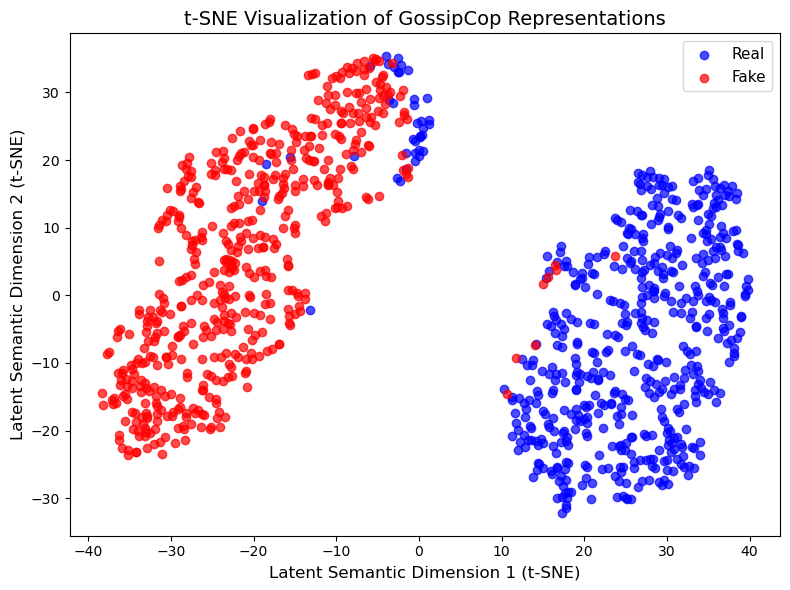

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Collect embeddings and labels
embeddings = []
labels = []

combined_model.eval()
for data1, data2 in zip(test_loader1, test_loader2):
    x1, edge_index1, batch1 = data1.x, data1.edge_index, data1.batch
    x2, edge_index2, batch2 = data2.x, data2.edge_index, data2.batch
    y = data1.y  # Labels

    _, expl = combined_model(x1, x2, edge_index1, edge_index2, batch1, return_embeddings=True)
    pooled = expl['pooled'].detach().cpu().numpy()
    embeddings.append(pooled)
    labels.append(y.cpu().numpy())

# Convert to arrays
embeddings = np.vstack(embeddings)
labels = np.concatenate(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Create figure
plt.figure(figsize=(8, 6))

# Separate by class for legend clarity
real_mask = (labels == 0)
fake_mask = (labels == 1)

plt.scatter(tsne_results[real_mask, 0], tsne_results[real_mask, 1],
            color='blue', label='Real', alpha=0.7)
plt.scatter(tsne_results[fake_mask, 0], tsne_results[fake_mask, 1],
            color='red', label='Fake', alpha=0.7)

# Axis labeling
plt.xlabel('Latent Semantic Dimension 1 (t-SNE)', fontsize=12)
plt.ylabel('Latent Semantic Dimension 2 (t-SNE)', fontsize=12)
plt.title('t-SNE Visualization of GossipCop Representations', fontsize=14)

# Legend instead of colorbar
plt.legend(title='', fontsize=11)
plt.tight_layout()

# Save and show
plt.savefig("tsne_gossipcop1.png", dpi=300)
plt.show()
